In [51]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import xgboost as xgb
import math
import os

%matplotlib inline

** Following function runs various transformations on the data **

In [52]:
def transform(df):
    # Rename some of the columns that have dashes in the name as they can be 
    #taken as minus by python
    df = df.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':\
                                'NumberOfTime30_59DaysPastDueNotWorse', 
                            'NumberOfTime60-89DaysPastDueNotWorse':\
                                'NumberOfTime60_89DaysPastDueNotWorse'})
    
    # Handle NAs. There are two features with NAs. MonthlyIncome and NumberOfDependents. 
    # We replace them with 0 (mean and median could be other choices, but
    # with 0 we get a good AUC value)
    df = df.fillna(value={'MonthlyIncome': 0, 
                          'NumberOfDependents': 0 })
    
    # Some of the features have large skewness. We use log transform to normalize the values. 
    # The log1p function is useful as it handles 0 values.
    df['MonthlyIncome'] = df.MonthlyIncome.apply(math.log1p)
    df['DebtRatio'] = df.DebtRatio.apply(math.log1p)
    df['RevolvingUtilizationOfUnsecuredLines'] = \
                            df.RevolvingUtilizationOfUnsecuredLines.apply(math.log1p)
    
    # Replace the NumberOfTimes90DaysLate, NumberOfTime60_89DaysPastDueNotWorse, 
    # and NumberOfTime30_59DaysPastDueNotWorse with a linear combination of the values. 
    # The coefficients are arbitrarily chosen but obtained after some trial and error.
    df['NumberOfTimesDaysLate'] = 101*df['NumberOfTimes90DaysLate'] + \
                                   51*df['NumberOfTime60_89DaysPastDueNotWorse'] + \
                                   23*df['NumberOfTime30_59DaysPastDueNotWorse']
            
    # Now drop these columns
    df = df.drop(['NumberOfTimes90DaysLate',
                  'NumberOfTime60_89DaysPastDueNotWorse',
                  'NumberOfTime30_59DaysPastDueNotWorse'], axis=1)
    
    return df

** Run Grid search to find optimal parameters **

Here we have done search for lambda (L2 reg), alpha (L1 reg), and gamma.

In [53]:
from sklearn.grid_search import GridSearchCV

def grid_search(x_train, y_train):
    cv_params = {'reg_lambda': [0,0.5,1.0], 
                 'reg_alpha': [0,0.5,1.0], 'gamma': [0,0.5,1.0]}
    ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 3, 'min_child_weight': 1,
                  'seed':42, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic'}
    gbm_opt = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, scoring='roc_auc', cv=5, n_jobs=-1)
    
    gbm_opt.fit(x_train,y_train)
    
    return gbm_opt

** Load and transform train/test data **

In [54]:
TRAIN_DATA_FILE = os.path.join('data','cs-training.csv')
TEST_DATA_FILE  = os.path.join('data','cs-test.csv')

In [55]:
train_df = pd.read_csv(TRAIN_DATA_FILE, index_col=0)
test_df = pd.read_csv(TEST_DATA_FILE,index_col=0)

** Removing duplicates is the recommended practice but it generates inferior results in our case **

In [56]:
#train_df = train_df.drop_duplicates(keep=False)

** Find correlation on raw data. ** 

Positive correlation is shown by:
* NumberOfTime30-59DaysPastDueNotWorse
* NumberOfTime60-89DaysPastDueNotWorse
* NumberOfTimes90DaysLate

Negative correlation is shown by:
* age (younger, more chance of delinquency)


In [57]:
corr_df = train_df.corr()

In [58]:
corr_df.SeriousDlqin2yrs

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines   -0.001802
age                                    -0.115386
NumberOfTime30-59DaysPastDueNotWorse    0.125587
DebtRatio                              -0.007602
MonthlyIncome                          -0.019746
NumberOfOpenCreditLinesAndLoans        -0.029669
NumberOfTimes90DaysLate                 0.117175
NumberRealEstateLoansOrLines           -0.007038
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046048
Name: SeriousDlqin2yrs, dtype: float64

In [59]:
train_df = transform(train_df)
test_df = transform(test_df)

** Remove any training data with age == 0 **

In [60]:
train_df = train_df[train_df.age > 0]

** Drop the SeriousDlqin2yrs from train and test data. Also set the data frames for features and ground truth **

In [61]:
y_train_df = train_df.SeriousDlqin2yrs
X_train_df = train_df.drop('SeriousDlqin2yrs', axis=1)

test_df = test_df.drop('SeriousDlqin2yrs', axis=1)

** The histogram for SeriousDlqin2yrs clearly shows large disparity between the binary truth classes. This
is a sign to make use of AUC metric as AUC is more robust in such cases **

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111dfa080>]], dtype=object)

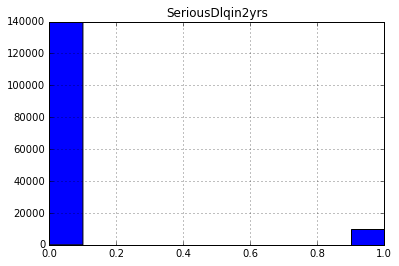

In [62]:
train_df.hist(column=['SeriousDlqin2yrs'])

In [63]:
random_state=42

** Do a 80-20 train/test split **

In [64]:
x_train, x_val, y_train, y_val = train_test_split(X_train_df, y_train_df, 
                                                    test_size=0.2, 
                                                    random_state=random_state, 
                                                    stratify=y_train_df)

** Following step takes a long time to run. The best values for alpha, lambda, and gamma are shown **

In [65]:
# Remove comments to run grid search
# gbm_opt = grid_search(x_train,y_train)

# gbm_opt.best_params_
# {'gamma': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}

** Convert pandas frames to XGBoost matrix for efficiency **

In [66]:
train_mat = xgb.DMatrix(x_train, y_train)

** Params for the XGBoost classifier. Some of these params are determined using a grid search (not shown here) **

In [67]:
params = {'eta':0.1, 'seed':random_state, 'subsample':0.8,
          'colsample_bytree':0.8, 'objective': 'binary:logistic', 
          'max_depth':3, 'min_child_weight':1, 'gamma':0, 'alpha':1, 'lambda':1}

** Run XGBoost cross validation with 5 stratified folds **

In [68]:
gbm_cv = xgb.cv(params=params, dtrain=train_mat, stratified=True,
                num_boost_round=3000, nfold=5, 
                metrics=['auc'], early_stopping_rounds=100)

** Check the max number of boost rounds. We later round up to nearest hundred **

In [69]:
gbm_cv.tail(5)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
229,0.865216,0.003026,0.876690,0.000654
230,0.865215,0.003015,0.876716,0.000646
231,0.865202,0.003005,0.876773,0.000665
232,0.865211,0.003007,0.876816,0.000671
233,0.865248,0.003006,0.876857,0.000662


** Do the training **

In [70]:
final_gbm = xgb.train(params, train_mat, num_boost_round=300) 

** Plot feature importance. RevolvingUtilizationOfUnsecuredLines, DebtRatio, and our constructed feature
NumberOfTimesDaysLate are among the top most important features **

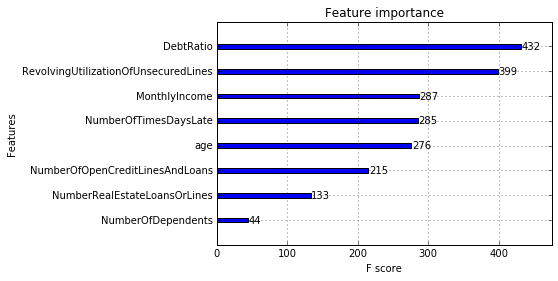

In [71]:
xgb.plot_importance(final_gbm)

** The following cells tests the model on hold-out data. We get an AUC score of 0.8698 which is well above
Kaggle benchmark **

In [72]:
val_mat = xgb.DMatrix(x_val)

In [73]:
y_preds = final_gbm.predict(val_mat)

In [74]:
metrics.roc_auc_score(y_val,y_preds)

#0.86984841878158681

0.86984841878158681

** Run the model on the test data and generate submission file **

In [75]:
test_mat = xgb.DMatrix(test_df)

In [76]:
final_preds = final_gbm.predict(test_mat)

In [77]:
final_preds

array([ 0.06121672,  0.0545834 ,  0.01288589, ...,  0.00436946,
        0.08630439,  0.0458273 ], dtype=float32)

In [78]:
submit_df = pd.DataFrame(data={'Id':np.arange(1,len(final_preds)+1),'Probability':final_preds})

In [79]:
SUBMIT_FILE = os.path.join('data','submission.csv')

In [80]:
submit_df.to_csv(SUBMIT_FILE, index=False)

Private Leader Board Score: 

![Private LB score](./images/PrivateLB.png)